In [19]:
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
Enables GPU for faster training
"""

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
"""
Defines a custom dataset in order to implement pytorch's built in model capabilities
"""

class RoverDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file, sep=";")
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data["Path"][idx]
        index = img_name.find("robocam")
        local_path = "IMG/" + img_name[index:]
        image = Image.open(local_path)

        steering_angle = self.data["SteerAngle"][idx]
        throttle = self.data["Throttle"][idx]
        
        steering_angle_tensor = torch.tensor(steering_angle, dtype=torch.float32)
        throttle_tensor = torch.tensor(throttle, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)

        return {'image': image, 'SteerAngle': steering_angle, 'Throttle': throttle}
        

In [4]:
"""
Defines a transformation of the collected images. The mean and std are commonly used image normalization values but can be experimented with.
"""

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize(            
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [12]:
sample_dataset = RoverDataset(csv_file ='robot_log.csv', root_dir='IMG', transform=transform)

In [13]:
"""
Split dataset into 90% train and 10% test
"""

train_size = int(0.9 * len(sample_dataset))
test_size = len(sample_dataset) - train_size

train_set, test_set = random_split(sample_dataset, [train_size, test_size])

In [14]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [15]:
"""
Decision to use pretrained resnet18 was somewhat arbitratry and would be good to experiment with other architectures
"""

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)

/home/exouser/.conda/envs/me592/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/.conda/envs/me592/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
"""
Opted to do a regression model. Both the loss function and optimizer would be good hyperparameters to experiment with
"""

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
"""
The model is trained on about 1500 images which is somewhat small. Didn't use a large number of epochs since the resnet model is pretrained.
"""

model.to(device)

for param in model.parameters():
    param.to(device)

train_history = []
test_history = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
    train_history.append(epoch_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images, targets = batch['image'].to(device), torch.stack((batch['SteerAngle'], batch['Throttle']), dim=1).to(device)
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss:.4f}")
    test_history.append(test_loss)
    
    


Epoch 1/20, Training Loss: 14.1932
Epoch 1/20, Test Loss: 10.5630
Epoch 2/20, Training Loss: 8.5665
Epoch 2/20, Test Loss: 5.2051
Epoch 3/20, Training Loss: 5.0873
Epoch 3/20, Test Loss: 4.3513
Epoch 4/20, Training Loss: 3.3743
Epoch 4/20, Test Loss: 3.2013
Epoch 5/20, Training Loss: 2.2064
Epoch 5/20, Test Loss: 2.1587
Epoch 6/20, Training Loss: 1.9795
Epoch 6/20, Test Loss: 1.8749
Epoch 7/20, Training Loss: 1.5603
Epoch 7/20, Test Loss: 1.7631
Epoch 8/20, Training Loss: 1.3440
Epoch 8/20, Test Loss: 1.2614
Epoch 9/20, Training Loss: 1.0828
Epoch 9/20, Test Loss: 1.3934
Epoch 10/20, Training Loss: 0.9450
Epoch 10/20, Test Loss: 1.3644
Epoch 11/20, Training Loss: 0.7700
Epoch 11/20, Test Loss: 1.1962
Epoch 12/20, Training Loss: 0.7757
Epoch 12/20, Test Loss: 1.3117
Epoch 13/20, Training Loss: 0.8386
Epoch 13/20, Test Loss: 1.5178
Epoch 14/20, Training Loss: 0.6722
Epoch 14/20, Test Loss: 1.3178
Epoch 15/20, Training Loss: 0.7901
Epoch 15/20, Test Loss: 1.2699
Epoch 16/20, Training Loss

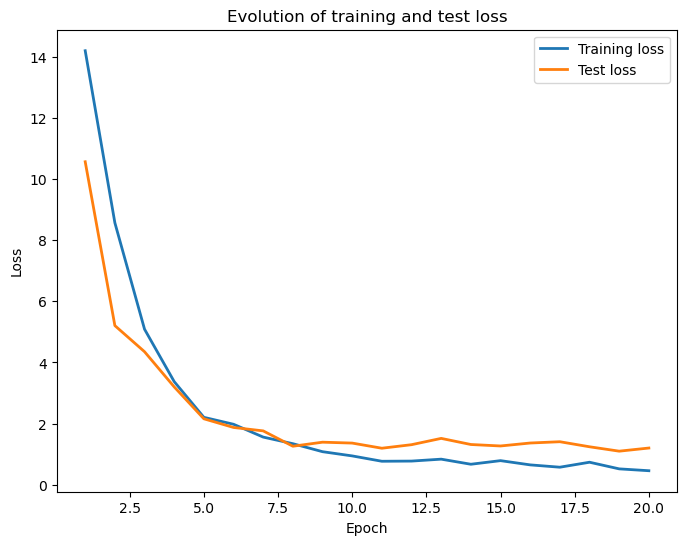

In [22]:
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, label="Training loss", linewidth=2)
    plt.plot(x, test_history, label="Test loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of training and test loss")
    plt.show()

In [24]:
print(train_history)

[14.193203502622017, 8.566458973551088, 5.087288433718401, 3.374316327621589, 2.2063585434387485, 1.9795325274230031, 1.5602797871532974, 1.3439905238263166, 1.0828346680843977, 0.9449916871951343, 0.7700075676363738, 0.7757130921994698, 0.8386257090819171, 0.6722193177599723, 0.7900540116391701, 0.6516905597003237, 0.575476682580165, 0.7382107409733816, 0.5212499928958095, 0.4605608578247624]
